# DDPM：去噪扩散概率模型学习笔记

In [33]:
from graphviz import Digraph
import matplotlib.pyplot as plt
from PIL import Image

## 1 数学基础

### 1 似然（Likelihood）
如果说概率衡量的是 $X$ 发生的可能性，那么似然衡量的就是 $X$ 发生时参数为 $θ$ 的可能性。因此，似然函数定义如下：
$$
L(\theta|X) = P(X|\theta)
$$
例如 $X=2$ 发生时，参数 $\theta = 1$ 的似然就是 $P(X=2|\theta = 1)$，在形式上与条件概率相同。

### 2 DDPM 中的 Markov Chain
马尔可夫性质是说，在给定当前状态 $x_t$ 的情况下，未来的状态 $x_{t+1}$ 只与当前状态 $x_t$ 有关，与过去的状态 $x_{t-1}, x_{t-2}, \cdots$ 无关。也就是说，当下的状态已经蕴含了过去的信息，因此立足当下就能预测未来。

在图片处理过程中需要经过多次处理，每次处理都会产生一张新的图片。把每一张图片都看作一个状态，那么图片处理的过程（把第 $t$ 张图变化为第 $t + 1$ 张图）就可以用一个条件概率来描述,对于第 $t$ 张图，它的生成离不开前面所有的图片，即：
$$
p(x_{t}|x_0,x_1,x_2,\cdots,x_{t-1})
$$
根据马尔可夫性质：
$$
p(x_t|x_{t-1}) = p(x_{t}|x_0,x_1,x_2,\cdots,x_{t-1})
$$
以上被称作状态之间的转移概率。

我们考虑联合分布，并应用马尔可夫性质：
$$
\begin{aligned}
p(x_0,x_1,x_2,\cdots,x_T)=p(x_0)p(x_1|x_0)p(x_2|x_0,x_1)p(x_3|x_0,x_1,x_2)\cdots \\
=p(x_0)p(x_1|x_0)p(x_2|x_1)p(x_3|x_2)\cdots \\
\end{aligned}
$$
这样，联合分布就简化为了众多的条件概率乘积，因此我们只需要了解逐步的概率转移分布，就可以逐步地变换图片，最终达成我们想要的结果了。这就是后面概率建模的理论基础。

### 3 变分推断和 ELBO
*这个 VAE 也用过*

假设 $p(z|x)$ 是难以计算的函数，而 $q(z)$ 是易于计算的函数且 $p≈q$，其散度为 $D_{KL}(p||q) = \mathbb{E}_{z\sim q}[log\frac{q}{p}]$（这个符号的意思是 $\int f(z)q(z)dz$）

然后把常数项提出来：
$$
D_{KL}(p||q) = \mathbb{E}_{z\sim q}[logp(x)+log\frac{q(z)}{p(z,x)}]=\mathbb{E}_{z\sim q}[log\frac{q(z)}{p(z,x)}]+logp(x)
$$

因此，
$$
const ~~ logp(x) = D + \mathbb{E}[log \frac{q}{p}]
$$
右边那一项被称为 ELBO，并有 $ELBO \leq LHS$

## 2 建模

### 1 前向过程/扩散过程
我们现在有一张图片 $\mathbf{x}_0$，我们需要将其转化为一张噪声图片 $\mathbf{x}_T$。（$T$ 是总时间步：也就是需要添加多少次噪声）。首先我们用如下的马尔可夫过程来表示逐步加入高斯噪声：
$$
q(\mathbf{x}_t|\mathbf{x}_{t-1}):=\mathcal{N}(\mathbf{x}_t;\sqrt{1-\beta_t}\mathbf{x}_{t-1},\beta_t\mathbf{I})
$$
由概率论：
$$
\mathbb{E}[\mathbf{x}_t \mid \mathbf{x}_{t-1}]=\sqrt{{\alpha}_t}\mathbf{x}_{t-1}
$$
$$
\mathbb{E}[\mathbb{E}[\mathbf{x}_t \mid \mathbf{x}_{t-1}]]=\mathbb{E}[\mathbf{x}_t]=\sqrt{{\alpha}_t}\mathbb{E}[\mathbf{x}_{t-1}]
$$
利用重参数化技巧:
$$
\mathbf{x}_t=\sqrt{{\alpha}_t}\mathbf{x}_{t-1}+\sqrt{1-{\alpha}_t}\mathbf{\epsilon}_t ~~ \mathrm{where} ~~ \mathbf{\epsilon}_t\sim\mathcal{N}(\mathbf{0},\mathbf{I})
$$
根据递推：
$$
\mathbf{x}_t=\sqrt{\prod_t{\alpha}_t}\mathbf{x}_{0}+\sqrt{1-\prod_t {\alpha}_t}\mathbf{\epsilon}_0 ~~...~~ (注意下标哦)
$$
*上式在展开的时候涉及到了独立正态分布相加，最终化为一个 $\epsilon_0$ 的过程*

*解释一下上式中涉及的i.i.d.正态分布之和：假设 $X$ 和 $Y$ 均为 $N(0,1)$，则 $aX+bY \sim N(0,a^2+b^2)$，可以标准化表示为 $\sqrt{a^2+b^2}Z$*

因此 $\mathbf{x}_t \sim \mathcal{N}({\prod_t {\alpha}_t}, ({1-\prod_t {\alpha}_t})\mathbf{I})$，在本篇论文中 $\alpha$ 和 $\beta$ 都是固定的并且位于 $(0,1)$，所以 $T$ 比较大时，$\mathbf{x}_T$ 就会趋近标准的正态分布。

需要指出的是，由于作者说了这两个“超参数”是固定的，因此前向扩散根本不需要搭建神经网络。<span style = "color:lightblue">但是这里要注意：前向过程在实际执行时并不是用的</span> $p(x_t|x_{t-1})$<span style = "color:lightblue">，而是用的</span> $q(x_t|x_0)$

### 2 反向过程/去噪过程
现在我们已经得到了一张纯噪声图，接下来定义一个神经网络，学习参数 $\theta$，执行反向的去噪过程（也是马尔可夫的）。
$$
\begin{aligned}
p_\theta(\mathbf{x}_{0:T}):=p(\mathbf{x}_T)\prod_{t=1}^Tp_\theta(\mathbf{x}_{t-1}|\mathbf{x}_t),\quad & p_\theta(\mathbf{x}_{t-1}|\mathbf{x}_t):=\mathcal{N}(\mathbf{x}_{t-1};\boldsymbol{\mu}_\theta(\mathbf{x}_t,t),\boldsymbol{\Sigma}_\theta(\mathbf{x}_t,t))
\end{aligned}
$$
也就是说我们每一步的转移概率分布都是正态分布，其参数由神经网络 $\theta$ 和时间步数 $t$ 决定。

### 3 思考：为什么要这样做？
原始图片涉及的概率分布是十分复杂的，并没有成熟的数学方法去描述。

但是我们通过加噪声的方式把图片变成一个正态分布，然后再用一系列的正态分布去转移它，让它逼近原始图片的概率分布。这个反向过程是很明朗的，而且很容易用数学去解释。

这其实和VAE很像，只不过VAE的着眼点在于控制图片生成背后的隐变量，并寻找它的规律，而在DDPM中我们只关心用一系列的马尔可夫过程去逼近原始的图片。

#### <span style="color: lightblue"> 为什么正向跳步而反向不跳步呢？ </span>
根据以上的推导，前向过程可以直接采样得到（全部分布都已知了，__所以我们并非是在跳步，而是在数学解析层面上推导出了结构，从而就没必要用代码去执行了__），但是反向除了一个高斯纯噪声以外，其他的都未知（根据重参数化，$\mathbf{x_0}$ 对我们而言是未知的，没法跳步）。而且我们的推导过程中用到了马尔可夫性质进行化简。因此，我们只能逐步进行。

### 4 优化目标函数

我们采用 $\mathbf{x}_0$ 的负对数似然（LHS）：

$$
\mathbb{E \left[-\log p_{\theta}(\mathbf{x}_0)\right]}
$$


这个 $p_\theta$ 是不好算的，我们回忆一下上文中的 $q$，这些全部是性质很好的正态分布，它们的先验分布我们全都知道，而且正好先验分布 $q_{t|t-1}$ 就是 $p_{\theta}$ 的后验。
如果能代入这个已知条件，问题就会简化很多。因此我们考虑利用变分下界的方法:

$$
\mathbb{E \left[-\log p_{\theta}(\mathbf{x}_0)\right]} \leq \mathbb{E} [-ELBO]=\mathbb{E}_q\left[-\log\frac{p_\theta(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T}|\mathbf{x}_0)}\right]
$$
这里我们代入 1.3 中的公式得到：
$$
-\mathbb{E}_q\left[\log p(\mathbf{x}_T)+\sum_{t\geq1}\log\frac{p_\theta(\mathbf{x}_{t-1}|\mathbf{x}_t)}{q(\mathbf{x}_t|\mathbf{x}_{t-1})}\right]=:L
$$

引入 **前向过程的后验分布** $q(\mathbf{x}_{t-1}|\mathbf{x}_t,\mathbf{x}_0)=\frac{q(\mathbf{x}_t|\mathbf{x}_{t-1})q(\mathbf{x}_{t-1}|\mathbf{x}_0)}{q(\mathbf{x}_t|\mathbf{x}_0)}$(这一分布也是正态分布，并且其参数已知)

代入原式中，可以简化为求多个正态分布之间的KL散度和：
$$
\mathbb{E}_q[L_T+\sum L_{t-1}+L_0]
$$
其中
$$
L_0=\log p_{\theta}(x_0\mid x_1)
$$
$$
L_{t-1}=D_{\mathrm{KL}}(q(\mathbf{x}_{t-1}|\mathbf{x}_{t},\mathbf{x}_{0})\parallel p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_{t}))
$$
$$
L_T=D_{\mathrm{KL}}(q(\mathbf{x}_{T}|\mathbf{x}_{0})\parallel p(\mathbf{x}_{T}))
$$

**这一步的好处在于，将一系列的复杂分布转换为了正态分布，因此可以直接用现有的解析解计算，简化了算法。**

<span style="color: lightblue"> 这里可以这样来理解: </span>
$q(\mathbf{x}_{t-1}|\mathbf{x}_{t},\mathbf{x}_{0})$ 可以理解为“已知 $x_0$ 和 $x_{t-1}$ 时，降噪到 $x_{t-1}$” 的客观过程。而
$p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_{t})$ 则表示我们实际需要学习的去噪过程。若这两步能相似的话，那就相当于<span style="color: green"> 我们虽然不知道具体的初始图像怎么样，但是我们做出的行为看起来就像我们知道初始图像一样 </span>

更严谨点说：

$\begin{aligned}&q(\mathbf{x}_{t-1}|\mathbf{x}_t,\mathbf{x}_0)\text{ 是理论上的逆向分布,表示“已知当前噪声状态 }\mathbf{x}_t\text{ 和初始图像 }\mathbf{x}_0\text{ 时,推导前一步状态 }\mathbf{x}_{t-1}\text{ 的条}\\&\text{件分布”。}\end{aligned}$

训练目标是让$p_\theta(\mathbf{x}_{t-1}|\mathbf{x}_t)$尽可能接近$q(\mathbf{x}_{t-1}|\mathbf{x}_t,\mathbf{x}_0)$。由于$q$依赖于$\mathbf{x}_0$,而$p_\theta$仅依赖$\mathbf{x}_t$,若两者相似，则说明模型在去噪时隐式恢复了$\mathrm{x}_0$的信息，尽管它并未显式知道$\mathbf{x}_0.$

### 5 预测噪声

**我们的目标是对 $p_{\theta}(x)$ 的参数进行优化，使得它逼近 $q$ 。（这也是KL散度的实际意义）**

根据上面的推导，我们可以把问题转化为对该分布的均值 $\mu_{\theta}$ 进行计算:
$$L_{t-1}=\mathbb{E}_q\left[\frac{1}{2\sigma_t^2}\|\tilde{\boldsymbol{\mu}}_t(\mathbf{x}_t,\mathbf{x}_0)-\boldsymbol{\mu}_\theta(\mathbf{x}_t,t)\|^2\right]+C$$

根据 2.1 的重参数化技巧。我们这里有：
$$\tilde{\mu}_t=\frac{1}{\sqrt{\alpha_t}}\left(x_t-\frac{\beta_t}{\sqrt{1-\alpha_t}}\epsilon\right)$$

**2.1的重参数化技巧形象地表现了这种加噪过程，那么对于反向去噪这一过程，我们也可以采用重参数化技巧，把对分布函数的研究变为对噪声的研究**

我们将 $\mu_{\theta}$ 重参数化为：
$$\begin{aligned}\frac{1}{\sqrt{\alpha_t}}\left(\mathbf{x}_t-\frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\boldsymbol{\epsilon}_\theta(\mathbf{x}_t,t)\right)\end{aligned}$$

最终的目标函数简化为 MSE 形式：
$$
\mathbb{E}_{\mathbf{x}_0,\epsilon}\left[||\epsilon - \epsilon_{\theta}||^2\right]
$$
**正如我们将前向的转移概率解释为添加噪声一样，我们反向的学习目标也通过重参数化，将涉及复杂概率分布的计算变为简单的噪声计算**

下面这张图展示了论文中一步步推导目标函数的过程


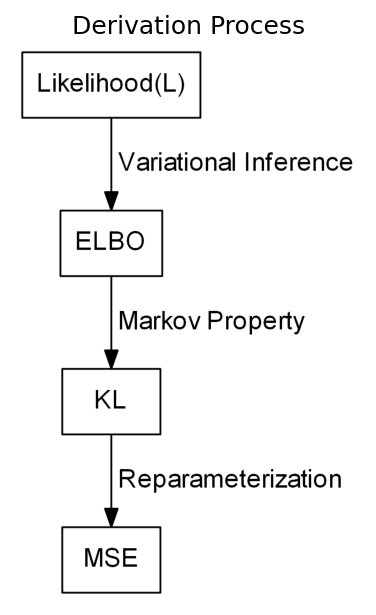

In [34]:
def Graph():
    dot = Digraph(comment='Optimization', node_attr={'fontname': 'Helvetica,Arial,sans-serif'},
                edge_attr={'fontname': 'Helvetica,Arial,sans-serif'},graph_attr={'size':'4,4'})
    dot.attr(dpi='300')

    dot.node('ll', 'Likelihood(L)', shape='rectangle')
    dot.node('el', 'ELBO', shape='rectangle')
    dot.node('kl', 'KL', shape='rectangle')
    dot.node('ms', 'MSE', shape='rectangle')

    dot.edge('ll', 'el', label=' Variational Inference')
    dot.edge('el', 'kl', label=' Markov Property')
    dot.edge('kl', 'ms', label=' Reparameterization')

    img_path = 'opt'
    dot.render(img_path, format='png', cleanup=True, view=False)
    print('下面这张图展示了论文中一步步推导目标函数的过程')
    img = Image.open(f'{img_path}.png')
    plt.title('Derivation Process')
    plt.rcParams['figure.dpi'] = 150
    plt.imshow(img)
    plt.axis('off')
    plt.show()
Graph()

## 3 代码复现
根据上面的学习，我们掌握了论文前3部分的内容，为了理解论文实验部分的一些要点，我们需要对代码进行复现。

学习自 [知乎专栏](https://zhuanlan.zhihu.com/p/638442430) 和 [GitHub](https://github.com/SingleZombie/DL-Demos/tree/master/dldemos/ddpm)

### 1 数据处理

length of MNIST 60000
<PIL.Image.Image image mode=L size=28x28 at 0x1C893E268A0>
9
torch.Size([1, 28, 28])
tensor(1.)
tensor(0.)


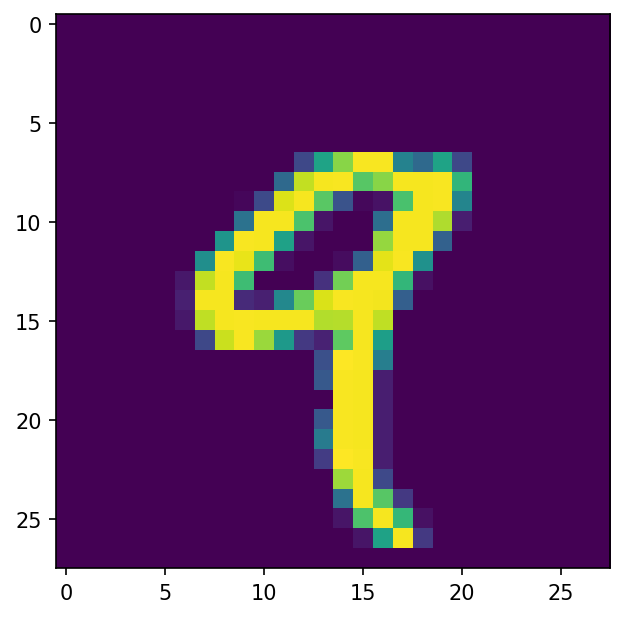

In [35]:
import torchvision
import torch
from torchvision.transforms import ToTensor
def download_dataset():
    mnist = torchvision.datasets.MNIST(root='./data/mnist', download=True)
    print('length of MNIST', len(mnist))
    id = 4
    img, label = mnist[id]
    print(img)
    print(label)

    # On computer with monitor
    # img.show()

    img.save('tmp.jpg')
    tensor = ToTensor()(img)
    print(tensor.shape)
    print(tensor.max())
    print(tensor.min())
    plt.imshow(img)
    plt.show()


download_dataset()

In [36]:
from torchvision.transforms import Compose,ToTensor,Lambda
from torch.utils.data import DataLoader
def get_dataloader(batch_size:int):
    transform = Compose([ToTensor(),Lambda(lambda x: (x-0.5)*2)]) # 归一化 [0,1]->[-1,1] 这样更适合正态分布
    dataset = torchvision.datasets.MNIST(root='./data/mnist',
                                         transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

def get_img_shape():
    return (1, 28, 28)

### 2 DDPM类
下面逐步实现
- 初始化函数：实现论文中的一些公式和预设参数
- 前向函数：加入噪声
- 反向函数：调用逐步反向函数
- 逐步反向函数：预测并减去噪声

In [37]:
# 定义一个名为 DDPM 的类，DDPM 是 Denoising Diffusion Probabilistic Models（去噪扩散概率模型）的缩写
class DDPM():

    # n_steps 就是论文里的 T，表示扩散过程的总步数
    def __init__(self,
                 device,  # 指定计算设备，如 'cpu' 或 'cuda'
                 n_steps: int,  # 扩散过程的总步数，是一个整数
                 min_beta: float = 0.0001,  # 最小的噪声系数 β，默认为 0.0001
                 max_beta: float = 0.02):  # 最大的噪声系数 β，默认为 0.02
        '''这里得到了论文中提出的一系列的噪声系数 α 和 β'''
        # 生成从 min_beta 到 max_beta 之间均匀分布的 n_steps 个噪声系数 β，并将其移动到指定设备上
        # torch.linspace 用于生成指定区间内的等间距数值
        betas = torch.linspace(min_beta, max_beta, n_steps).to(device)
        # 根据噪声系数 β 计算对应的 α 值，α = 1 - β
        alphas = 1 - betas
        # 创建一个与 alphas 形状相同的空张量 alpha_bars，用于存储累积的 α 值
        alpha_bars = torch.empty_like(alphas)
        # 初始化累积乘积变量 product 为 1
        product = 1
        # 遍历 alphas 中的每个 α 值
        for i, alpha in enumerate(alphas):
            # 计算累积乘积，即 \bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s
            product *= alpha
            # 将累积乘积赋值给 alpha_bars 中对应的位置
            alpha_bars[i] = product
        # 将计算得到的噪声系数 β 存储为类的属性，方便后续使用
        self.betas = betas
        # 将扩散过程的总步数 n_steps 存储为类的属性
        self.n_steps = n_steps
        # 将计算得到的 α 值存储为类的属性
        self.alphas = alphas
        # 将计算得到的累积 α 值 \bar{\alpha} 存储为类的属性
        self.alpha_bars = alpha_bars

    '''前向'''
    def sample_forward(self, x, t, eps=None):
        alpha_bar = self.alpha_bars[t].reshape(-1, 1, 1, 1)
        if eps is None:
            eps = torch.randn_like(x)
        res = eps * torch.sqrt(1 - alpha_bar) + torch.sqrt(alpha_bar) * x # 这里是论文中提到的重参数化后的公式
        return res
    
    '''后向'''
    def sample_backward(self, img_shape, net, device, simple_var=True):
        x = torch.randn(img_shape).to(device)  # 初始化为纯噪声
        net = net.to(device) # U-Net
        for t in range(self.n_steps - 1, -1, -1):  # 从最大时间步逆序执行
            x = self.sample_backward_step(x, t, net, simple_var)
        return x  # 最终生成去噪后的图像
    # 根据论文，预测分布等价于预测噪声，所以用减去噪声来实现
    def sample_backward_step(self, x_t, t, net, simple_var=True):
        n = x_t.shape[0]
        t_tensor = torch.tensor([t] * n, dtype=torch.long).to(x_t.device).unsqueeze(1)
        eps = net(x_t, t_tensor)  # 预测当前噪声 这里使用UNet
        
        # 计算方差和噪声
        if t == 0:
            noise = 0  # 最后一步不加噪声
        else:
            if simple_var:
                var = self.betas[t]  # 简化方差（对应DDPM）
            else:
                var = (1 - self.alpha_bars[t-1]) / (1 - self.alpha_bars[t]) * self.betas[t]  # 修正方差（对应改进方法）
            noise = torch.randn_like(x_t) * torch.sqrt(var)
        
        # 计算均值并更新x_t
        mean = (x_t - (1 - self.alphas[t]) / torch.sqrt(1 - self.alpha_bars[t]) * eps) / torch.sqrt(self.alphas[t])
        x_t = mean + noise
        return x_t # 到这里就完成一步去噪了
        

执行前向过程可视化

这是前向扩散的过程


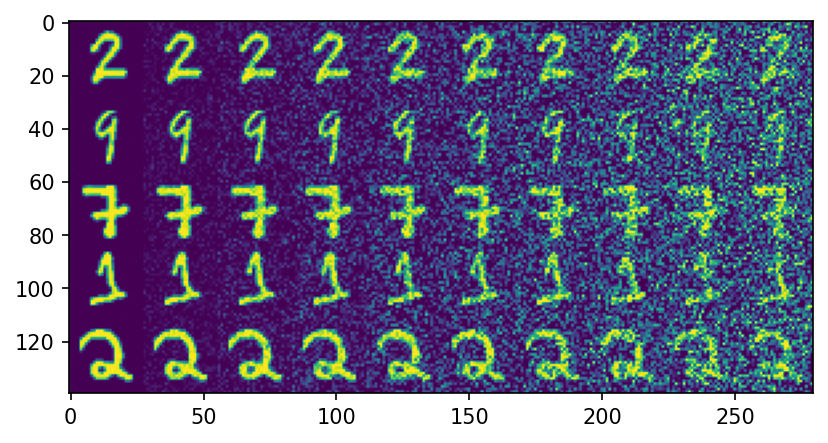

In [38]:
import cv2
import einops
import numpy as np

def visualize_forward():
    n_steps = 100
    device = 'cuda'
    dataloader = get_dataloader(5)
    x, _ = next(iter(dataloader))
    x = x.to(device)

    ddpm = DDPM(device, n_steps)
    xts = []
    percents = torch.linspace(0, 0.99, 10)
    for percent in percents:
        t = torch.tensor([int(n_steps * percent)])
        t = t.unsqueeze(1)
        x_t = ddpm.sample_forward(x, t)
        xts.append(x_t)
    res = torch.stack(xts, 0)
    res = einops.rearrange(res, 'n1 n2 c h w -> (n2 h) (n1 w) c')
    res = (res.clip(-1, 1) + 1) / 2 * 255
    res = res.cpu().numpy().astype(np.uint8)

    cv2.imwrite('diffusion_forward.jpg', res)
    plt.imshow(res)
    print("这是前向扩散的过程")

visualize_forward()

### 3 神经网络

In [39]:
import torch.nn as nn
import torch.nn.functional as F

我们接下来实现以下内容：
- 位置编码

#### 1 位置编码
编码的意义是：
- 将时间步的信息嵌入到图像的通道(Channel)中
- 将时间步映射为高维向量，使得模型可以更好地学习时间步的信息

通道是网络学习出的特征。在 U-Net 编码时，通道数是逐渐增加的，而解码时，通道数是逐渐减少的。

In [40]:
class PositionalEncoding(nn.Module):
    """将离散时间步编码为连续向量（类似Transformer位置编码）"""
    def __init__(self, max_seq_len: int, d_model: int):
        """
        Args:
            max_seq_len: 最大时间步数（如DDPM的1000步）
            d_model:     编码维度（需为偶数）
        """
        super().__init__()
        assert d_model % 2 == 0  # 确保维度为偶数便于计算

        # 生成位置编码矩阵（核心公式）
        pe = torch.zeros(max_seq_len, d_model)
        i_seq = torch.linspace(0, max_seq_len - 1, max_seq_len)  # 时间轴 [0,1,...,max_seq_len-1]
        j_seq = torch.linspace(0, d_model - 2, d_model // 2)     # 维度轴（步长为2）
        pos, two_i = torch.meshgrid(i_seq, j_seq)                # 构建网格坐标
        
        # 正弦/余弦交替编码（Transformer经典方法）
        pe_2i = torch.sin(pos / 10000**(two_i / d_model))       # 偶数位置用sin
        pe_2i_1 = torch.cos(pos / 10000**(two_i / d_model))     # 奇数位置用cos
        pe = torch.stack((pe_2i, pe_2i_1), 2).reshape(max_seq_len, d_model)

        # 转换为可查询的嵌入层（不可训练）
        self.embedding = nn.Embedding(max_seq_len, d_model)
        self.embedding.weight.data = pe
        self.embedding.requires_grad_(False)  # 冻结参数

    def forward(self, t):
        """输入形状 (batch_size), 输出形状 (batch_size, d_model)"""
        return self.embedding(t)

#### 2 残差块
我们先简要讲解一下残差网络的原理。

残差神经网络(ResNet):
这个东西被创造出来是为了解决 __梯度消失/爆炸__ 和 __网络退化（为什么我刷的题比你多还考的比你差！？？）__ 的问题。我们知道神经网络其实就是在学习一个复杂函数 $H(x)$ 的参数 $w$，然后用损失函数的梯度指导 $w$ 的更新。传统的神经网络需要不断重复地学习，遍历所有层：
```cpp
(Input from former layers) x -> Layers -> f(x) -> (Output to next layers)
```
ResNet 的思想是，既然已经得到了 `Input` $x$，我们把它记录下来，求它与 $H(x)$ 之间的残差 $F(x)=H(x)-x$，然后把 $F(x)$ 作为新的 `Input`，继续学习。这样中间那些层只需要学习一个更加简单的函数：（以下示例为恒等跳跃）
```cpp
(Input from former layers) x -> Layers -> F(x) -> F(x) + x -> (Output to next layers)
                |                                  |
                +----------------------------------+
```
这样，中间层的任务更加轻松，而且就算中间层学得不好，我至少保留了原始的 `Input` $x$ 不被污染。
> 就像一个人第一次考试考了80分，如果给他指出错误然后针对性地修改错题，那么他的成绩就会显著升高。就算他没有纠正那些错误，他对的题还是对的，能保住原来的分。
> 但如果他不知道错在哪里，直接重新做一遍，那么他就有可能把之前做正确的题也给改错，成绩反而可能下降。

In [41]:
class ResidualBlock(nn.Module):
    """带短路连接的残差块（解决梯度消失问题）"""
    def __init__(self, in_c: int, out_c: int):
        """
        Args:
            in_c:  输入通道数
            out_c: 输出通道数
        """
        super().__init__()
        # 主路径（两卷积层）
        self.conv1 = nn.Conv2d(in_c, out_c, 3, 1, 1)  # 3x3卷积，保持尺寸
        self.bn1 = nn.BatchNorm2d(out_c)
        self.actvation1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_c, out_c, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.actvation2 = nn.ReLU()

        # 短路连接（通道数变化时用1x1卷积调整）
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_c, out_c, 1),  # 1x1卷积改变通道数
            nn.BatchNorm2d(out_c)
        ) if in_c != out_c else nn.Identity()

    def forward(self, input):
        """前向传播：主路径 + 短路连接"""
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.actvation1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += self.shortcut(input)  # 残差连接（核心！）
        x = self.actvation2(x)
        return x

#### 3 ResNet

In [42]:
class ConvNet(nn.Module):
    """扩散模型主干网络（可配置时间步注入方式）"""
    def __init__(self,
                 n_steps,
                 intermediate_channels=[10, 20, 40],  # 中间层通道数配置
                 pe_dim=10,                            # 位置编码维度
                 insert_t_to_all_layers=False):        # 是否每层都注入时间信息
        super().__init__()
        C, H, W = get_img_shape()  # 获取输入图像形状（如1x28x28）
        self.pe = PositionalEncoding(n_steps, pe_dim)

        # 时间编码线性层（控制时间信息注入方式）
        self.pe_linears = nn.ModuleList()
        self.all_t = insert_t_to_all_layers
        if not insert_t_to_all_layers:
            self.pe_linears.append(nn.Linear(pe_dim, C))  # 仅在首层注入

        # 构建残差块序列
        self.residual_blocks = nn.ModuleList()
        prev_channel = C  # 初始通道数（随层变化）
        for channel in intermediate_channels:
            self.residual_blocks.append(ResidualBlock(prev_channel, channel))
            # 根据配置添加线性层
            if insert_t_to_all_layers:
                self.pe_linears.append(nn.Linear(pe_dim, prev_channel))
            else:
                self.pe_linears.append(None)
            prev_channel = channel  # 更新通道数

        self.output_layer = nn.Conv2d(prev_channel, C, 3, 1, 1)  # 输出层还原通道数

    def forward(self, x, t):
        """前向传播（关键时间步注入流程）"""
        n = t.shape[0]  # batch_size
        t = self.pe(t)  # 获取位置编码 (n, pe_dim)
        
        # 逐层处理：残差块 + 时间注入
        for m_x, m_t in zip(self.residual_blocks, self.pe_linears):
            if m_t is not None:
                pe = m_t(t).reshape(n, -1, 1, 1)  # 调整形状为 (n, channel, 1, 1)
                x = x + pe  # 广播机制注入时间信息
            x = m_x(x)      # 残差块处理
        x = self.output_layer(x)
        return x

#### 4 U-Net
这个神经网络是一种“编码-解码式”的网络结构，并且它也有跳跃连接(实现了高分辨率图像的信息被保留并传给对应的解码器的功能，__注意这个跳跃连接和 Resnet 里的那个不一样__ )。

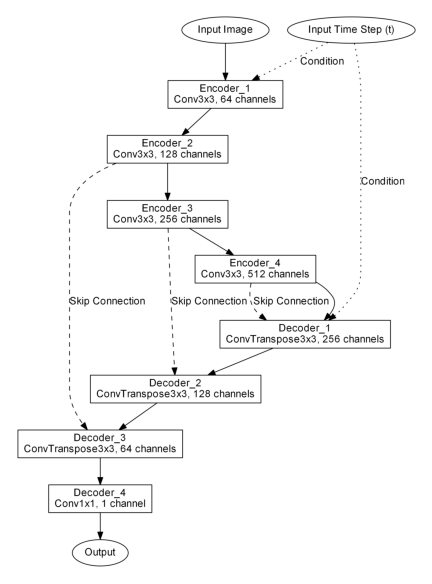

In [43]:
import matplotlib.image as mpimg

def Graph_of_U_Net():
    dot = Digraph(comment='DDPM U-Net Network', node_attr={'fontname': 'Helvetica,Arial,sans-serif'},
                  edge_attr={'fontname': 'Helvetica,Arial,sans-serif'})
    dot.attr(rankdir='TB', dpi='300')

    # 定义编码器层信息
    encoder_layers = [
        ('Encoder_1', 'Conv3x3, 64 channels'),
        ('Encoder_2', 'Conv3x3, 128 channels'),
        ('Encoder_3', 'Conv3x3, 256 channels'),
        ('Encoder_4', 'Conv3x3, 512 channels')
    ]

    # 定义解码器层信息
    decoder_layers = [
        ('Decoder_1', 'ConvTranspose3x3, 256 channels'),
        ('Decoder_2', 'ConvTranspose3x3, 128 channels'),
        ('Decoder_3', 'ConvTranspose3x3, 64 channels'),
        ('Decoder_4', 'Conv1x1, 1 channel')
    ]

    # 添加输入节点（图像和时间步）
    dot.node('Input_Image', label='Input Image', shape='ellipse')
    dot.node('Input_Time', label='Input Time Step (t)', shape='ellipse')

    # 添加编码器节点和边
    for i, (layer_name, params) in enumerate(encoder_layers):
        dot.node(layer_name, label=f"{layer_name}\n{params}", shape='box')
        if i == 0:
            # 图像输入到第一个编码器层
            dot.edge('Input_Image', layer_name)
            # 时间步输入到第一个编码器层
            dot.edge('Input_Time', layer_name, style='dotted', label='Condition')
        else:
            dot.edge(encoder_layers[i - 1][0], layer_name)

    # 添加解码器节点和边
    for i, (layer_name, params) in enumerate(decoder_layers):
        dot.node(layer_name, label=f"{layer_name}\n{params}", shape='box')
        if i == 0:
            # 最后一个编码器层连接到第一个解码器层
            dot.edge(encoder_layers[-1][0], layer_name)
            # 时间步也输入到第一个解码器层
            dot.edge('Input_Time', layer_name, style='dotted', label='Condition')
        else:
            dot.edge(decoder_layers[i - 1][0], layer_name)

    # 添加跳跃连接边
    for i in range(len(encoder_layers) - 1, 0, -1):
        dot.edge(encoder_layers[i][0], decoder_layers[len(encoder_layers) - i - 1][0], style='dashed', label='Skip Connection')

    # 添加输出节点
    dot.node('Output', label='Output', shape='ellipse')
    dot.edge(decoder_layers[-1][0], 'Output')

    # 保存图形
    img_path = 'unet_ddpm'
    dot.render(img_path, format='png', cleanup=True, view=False)

    # 使用 matplotlib 显示图像
    img = mpimg.imread(f'{img_path}.png')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

Graph_of_U_Net()

In [44]:
class ConvNet(nn.Module):

    def __init__(self,
                 n_steps,
                 intermediate_channels=[10, 20, 40],
                 pe_dim=10,
                 insert_t_to_all_layers=False):
        super().__init__()
        C, H, W = get_img_shape()  # 1, 28, 28
        self.pe = PositionalEncoding(n_steps, pe_dim)

        self.pe_linears = nn.ModuleList()
        self.all_t = insert_t_to_all_layers
        if not insert_t_to_all_layers:
            self.pe_linears.append(nn.Linear(pe_dim, C))

        self.residual_blocks = nn.ModuleList()
        prev_channel = C
        for channel in intermediate_channels:
            self.residual_blocks.append(ResidualBlock(prev_channel, channel))
            if insert_t_to_all_layers:
                self.pe_linears.append(nn.Linear(pe_dim, prev_channel))
            else:
                self.pe_linears.append(None)
            prev_channel = channel
        self.output_layer = nn.Conv2d(prev_channel, C, 3, 1, 1)

    def forward(self, x, t):
        n = t.shape[0]
        t = self.pe(t)
        for m_x, m_t in zip(self.residual_blocks, self.pe_linears):
            if m_t is not None:
                pe = m_t(t).reshape(n, -1, 1, 1)
                x = x + pe
            x = m_x(x)
        x = self.output_layer(x)
        return x


class UnetBlock(nn.Module):

    def __init__(self, shape, in_c, out_c, residual=False):
        super().__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, 3, 1, 1)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, 1, 1)
        self.activation = nn.ReLU()
        self.residual = residual
        if residual:
            if in_c == out_c:
                self.residual_conv = nn.Identity()
            else:
                self.residual_conv = nn.Conv2d(in_c, out_c, 1)

    def forward(self, x):
        out = self.ln(x)
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        if self.residual:
            out += self.residual_conv(x)
        out = self.activation(out)
        return out


class UNet(nn.Module):

    def __init__(self,
                 n_steps,
                 channels=[10, 20, 40, 80],
                 pe_dim=10,
                 residual=False) -> None:
        super().__init__()
        C, H, W = get_img_shape()
        layers = len(channels)
        Hs = [H]
        Ws = [W]
        cH = H
        cW = W
        for _ in range(layers - 1):
            cH //= 2
            cW //= 2
            Hs.append(cH)
            Ws.append(cW)

        self.pe = PositionalEncoding(n_steps, pe_dim)

        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.pe_linears_en = nn.ModuleList()
        self.pe_linears_de = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        prev_channel = C
        for channel, cH, cW in zip(channels[0:-1], Hs[0:-1], Ws[0:-1]):
            self.pe_linears_en.append(
                nn.Sequential(nn.Linear(pe_dim, prev_channel), nn.ReLU(),
                              nn.Linear(prev_channel, prev_channel)))
            self.encoders.append(
                nn.Sequential(
                    UnetBlock((prev_channel, cH, cW),
                              prev_channel,
                              channel,
                              residual=residual),
                    UnetBlock((channel, cH, cW),
                              channel,
                              channel,
                              residual=residual)))
            self.downs.append(nn.Conv2d(channel, channel, 2, 2))
            prev_channel = channel

        self.pe_mid = nn.Linear(pe_dim, prev_channel)
        channel = channels[-1]
        self.mid = nn.Sequential(
            UnetBlock((prev_channel, Hs[-1], Ws[-1]),
                      prev_channel,
                      channel,
                      residual=residual),
            UnetBlock((channel, Hs[-1], Ws[-1]),
                      channel,
                      channel,
                      residual=residual),
        )
        prev_channel = channel
        for channel, cH, cW in zip(channels[-2::-1], Hs[-2::-1], Ws[-2::-1]):
            self.pe_linears_de.append(nn.Linear(pe_dim, prev_channel))
            self.ups.append(nn.ConvTranspose2d(prev_channel, channel, 2, 2))
            self.decoders.append(
                nn.Sequential(
                    UnetBlock((channel * 2, cH, cW),
                              channel * 2,
                              channel,
                              residual=residual),
                    UnetBlock((channel, cH, cW),
                              channel,
                              channel,
                              residual=residual)))

            prev_channel = channel

        self.conv_out = nn.Conv2d(prev_channel, C, 3, 1, 1)

    def forward(self, x, t):
        n = t.shape[0]
        t = self.pe(t)
        encoder_outs = []
        for pe_linear, encoder, down in zip(self.pe_linears_en, self.encoders,
                                            self.downs):
            pe = pe_linear(t).reshape(n, -1, 1, 1)
            x = encoder(x + pe)
            encoder_outs.append(x)
            x = down(x)
        pe = self.pe_mid(t).reshape(n, -1, 1, 1)
        x = self.mid(x + pe)
        for pe_linear, decoder, up, encoder_out in zip(self.pe_linears_de,
                                                       self.decoders, self.ups,
                                                       encoder_outs[::-1]):
            pe = pe_linear(t).reshape(n, -1, 1, 1)
            x = up(x)

            pad_x = encoder_out.shape[2] - x.shape[2]
            pad_y = encoder_out.shape[3] - x.shape[3]
            x = F.pad(x, (pad_x // 2, pad_x - pad_x // 2, pad_y // 2,
                          pad_y - pad_y // 2))
            x = torch.cat((encoder_out, x), dim=1)
            x = decoder(x + pe)
        x = self.conv_out(x)
        return x


convnet_small_cfg = {
    'type': 'ConvNet',
    'intermediate_channels': [10, 20],
    'pe_dim': 128
}

convnet_medium_cfg = {
    'type': 'ConvNet',
    'intermediate_channels': [10, 10, 20, 20, 40, 40, 80, 80],
    'pe_dim': 256,
    'insert_t_to_all_layers': True
}
convnet_big_cfg = {
    'type': 'ConvNet',
    'intermediate_channels': [20, 20, 40, 40, 80, 80, 160, 160],
    'pe_dim': 256,
    'insert_t_to_all_layers': True
}

unet_1_cfg = {'type': 'UNet', 'channels': [10, 20, 40, 80], 'pe_dim': 128}
unet_res_cfg = {
    'type': 'UNet',
    'channels': [10, 20, 40, 80],
    'pe_dim': 128,
    'residual': True
}


def build_network(config: dict, n_steps):
    network_type = config.pop('type')
    if network_type == 'ConvNet':
        network_cls = ConvNet
    elif network_type == 'UNet':
        network_cls = UNet

    network = network_cls(n_steps, **config)
    return network

### 4 训练
__Algorithm  Training__

1. 循环
2. $x_0 \sim q(x_0)$ 从原始数据分布中采干净的样本（没有噪声）
3. $t \sim Uniform(\{1,...,T\})$ 从时间步中随机采样，随机训练一个时间步
4. $\epsilon \sim \mathcal{N}(0, I)$ 从标准正态分布中采样
5. Take gradient descent step on 
$\nabla_{\theta} \|\epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}\epsilon,t)\|^2$ 这是论文中推导的损失函数公式
1. 模型收敛时终止循环

In [45]:
import os
import time
import einops

batch_size = 512
n_epochs = 100

def train(ddpm: DDPM, net, device, ckpt_path):
    # n_steps 就是公式里的 T
    # net 是某个继承自 torch.nn.Module 的神经网络
    n_steps = ddpm.n_steps
    dataloader = get_dataloader(batch_size)
    net = net.to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), 1e-3)

    for e in range(n_epochs):
        for x, _ in dataloader:
            current_batch_size = x.shape[0]
            x = x.to(device)
            t = torch.randint(0, n_steps, (current_batch_size, )).to(device)
            eps = torch.randn_like(x).to(device)
            x_t = ddpm.sample_forward(x, t, eps)
            eps_theta = net(x_t, t.reshape(current_batch_size, 1))
            loss = loss_fn(eps_theta, eps)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    torch.save(net.state_dict(), ckpt_path)

### 5 执行

In [46]:
def sample_imgs(ddpm,
                net,
                output_path,
                n_sample=81,
                device='cuda',
                simple_var=True):
    net = net.to(device)
    net = net.eval()
    with torch.no_grad():
        shape = (n_sample, *get_img_shape())  # 1, 3, 28, 28
        imgs = ddpm.sample_backward(shape,
                                    net,
                                    device=device,
                                    simple_var=simple_var).detach().cpu()
        imgs = (imgs + 1) / 2 * 255
        imgs = imgs.clamp(0, 255)
        imgs = einops.rearrange(imgs,
                                '(b1 b2) c h w -> (b1 h) (b2 w) c',
                                b1=int(n_sample**0.5))

        imgs = imgs.numpy().astype(np.uint8)

        cv2.imwrite(output_path, imgs)


configs = [
    convnet_small_cfg, convnet_medium_cfg, convnet_big_cfg, unet_1_cfg,
    unet_res_cfg
]

运行下面的单元格进行训练

In [47]:
torch.cuda.is_available()

True

In [48]:
os.makedirs('work_dirs', exist_ok=True)

n_steps = 1000
config_id = 4
device = 'cuda'
model_path = 'work_dirs/model_unet_res.pth'

config = configs[config_id]
net = build_network(config, n_steps)
ddpm = DDPM(device, n_steps)

train(ddpm, net, device=device, ckpt_path=model_path)

net.load_state_dict(torch.load(model_path))
sample_imgs(ddpm, net, 'work_dirs/diffusion.jpg', device=device)

让我们康康结果

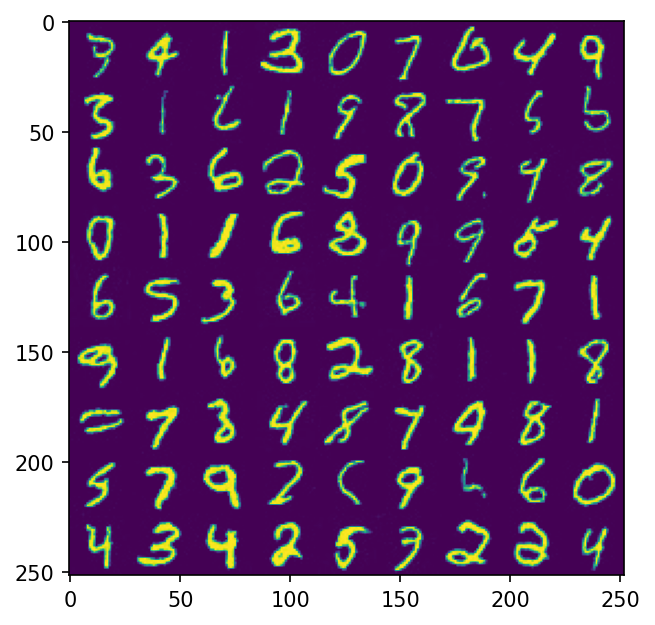

In [51]:
RESULT = plt.imread('work_dirs/diffusion.jpg')
plt.imshow(RESULT)

### 6 代码解释栏
1. `alpha_bar = self.alpha_bars[t].reshape(-1, 1, 1, 1)` 的操作
   即以 `t` 中的值为 `alpha_bar` 中的索引，取出 `alpha_bar` 中的对应值。我们知道 `t` 储存着一批次的时间步信息，这样我们就可以取出对应的 `alpha_bar` 值了。

In [ ]:
def explain1():
    a = torch.tensor([1,2,3,4,5,6])
    b = torch.tensor([0,2,4,1,3])
    return a[b]
explain1()